In [1]:
import sys
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (cross_val_score, 
                                     RandomizedSearchCV, 
                                     StratifiedKFold)
from sklearn.metrics import (confusion_matrix, 
                             classification_report,
                             f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from skopt import BayesSearchCV

import warnings
warnings.simplefilter(action='ignore')

PROJ_ROOT = os.pardir
data_dir = join(PROJ_ROOT, 'data')

visuals_dir = join(PROJ_ROOT, 'notebooks', 'visuals')

src_dir = join(PROJ_ROOT, 'notebooks', 'src')
sys.path.append(src_dir)

from src.preprocessing import PreprocessorLinear 

In [2]:
bank_data_train = join(PROJ_ROOT, 'data', 'bank_train_clean.csv')
bank_data_val = join(PROJ_ROOT, 'data', 'bank_val_clean.csv')

bank_train = pd.read_csv(bank_data_train)
bank_val = pd.read_csv(bank_data_val)

# get our target
cust_response_train = bank_train['y']
cust_response_val = bank_val['y']

# get our features
bank_feats_train = bank_train.drop('y', axis=1)
bank_feats_val = bank_val.drop('y', axis=1)

## Logisitic Regression (Baseline)

In [3]:
# standardize & dummy features for linear model
preprocess = PreprocessorLinear()
bank_feats_train = preprocess.fit_transform(bank_feats_train)
bank_feats_val = preprocess.transform(bank_feats_val)

In [4]:
skf = StratifiedKFold(n_splits=5)
lr = LogisticRegression(class_weight='balanced',
                        random_state=12,
                        n_jobs=-1)

param_distribution = {'penalty': ['l1', 'l2'],
                      'C': [0.01, 0.05, 0.1, 0.5, 1.0,]}

lr_rnd_search = RandomizedSearchCV(lr,
                                   param_distribution,
                                   n_iter=5,
                                   scoring='f1',
                                   n_jobs=-1,
                                   cv=skf,
                                   random_state=6)

lr_rnd_search.fit(bank_feats_train, cust_response_train)
score = lr_rnd_search.best_score_
best_params = lr_rnd_search.best_params_

print(f'Best f1 score --- {score}')
print(f'Best parameters found:\n---{best_params}')

Best f1 score --- 0.43580746292843
Best parameters found:
---{'penalty': 'l2', 'C': 0.01}


In [5]:
lr_best = lr_rnd_search.best_estimator_
lr_best.fit(bank_feats_train, cust_response_train)

cust_predictions = lr_best.predict(bank_feats_val)
cust_true = cust_response_val

In [6]:
print(pd.DataFrame(confusion_matrix(
    cust_true, cust_predictions), columns=['Pred_Neg', 'Pred_Pos'], index=['True_Neg', 'True_Pos'])
)
print(f'\n{classification_report(cust_true, cust_predictions)}')

          Pred_Neg  Pred_Pos
True_Neg      6057      1176
True_Pos       335       580

              precision    recall  f1-score   support

           0       0.95      0.84      0.89      7233
           1       0.33      0.63      0.43       915

    accuracy                           0.81      8148
   macro avg       0.64      0.74      0.66      8148
weighted avg       0.88      0.81      0.84      8148



## Random Forest

In [7]:
skf = StratifiedKFold(n_splits=5)
rf = RandomForestClassifier(n_estimators=100, 
                            class_weight='balanced', 
                            random_state=6, n_jobs=-1)

param_distribution = {'max_features': [0.8, 0.75, 0.7, 0.65],
                      'max_depth': [5, 10, 12, 15, 18, 20],
                      'min_samples_leaf': [7, 10, 12, 15, 20]}

rf_rnd_search = RandomizedSearchCV(rf,
                                   param_distribution,
                                   n_iter=10,
                                   scoring='f1',
                                   n_jobs=-1,
                                   cv=skf,
                                   random_state=9)

rf_rnd_search.fit(bank_feats_train, cust_response_train)
rf_score = rf_rnd_search.best_score_
rf_best_params = rf_rnd_search.best_params_

print(f'Best f1 score --- {rf_score}')
print(f'Best parameters found:\n---{rf_best_params}')

Best f1 score --- 0.5055790835813079
Best parameters found:
---{'min_samples_leaf': 7, 'max_features': 0.75, 'max_depth': 18}


In [8]:
rf_best = rf_rnd_search.best_estimator_
rf_best.fit(bank_feats_train, cust_response_train)

rf_cust_predictions = rf_best.predict(bank_feats_val)

print(pd.DataFrame(confusion_matrix(
    cust_true, rf_cust_predictions), columns=['Pred_Neg', 'Pred_Pos'], index=['True_Neg', 'True_Pos'])
)
print(f'\n{classification_report(cust_true, rf_cust_predictions)}')

          Pred_Neg  Pred_Pos
True_Neg      6555       678
True_Pos       400       515

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      7233
           1       0.43      0.56      0.49       915

    accuracy                           0.87      8148
   macro avg       0.69      0.73      0.71      8148
weighted avg       0.89      0.87      0.88      8148



## xgboost

In [9]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, 
                            tree_method='approx',
                            n_jobs=-1)

xgb_bayes_search = BayesSearchCV(
    estimator = xgb_clf,
    search_spaces = {
        'learning_rate': (0.001, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'booster': ('gbtree', 'dart'),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-5, 1000, 'log-uniform'),
        'reg_alpha': (1e-5, 1.0, 'log-uniform'),
        'gamma': (1e-6, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 75, 100, 125, 150),
        'scale_pos_weight': (1, 4, 7, 10, 12, 15, 20)
    },    
    scoring = 'f1',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=24
    ),
    n_jobs=-1,
    n_iter=9,   
    verbose=0,
    refit=True,
    random_state=24 
)

def model_hyperparameters(optim_result):
    """Status callback durring hyperparameter search"""
    
    models = pd.DataFrame(xgb_bayes_search.cv_results_)    
    
    # current and best parameters    
    best_params = pd.Series(xgb_bayes_search.best_params_)
    print(f'Model #{len(models)}\nBest f1 so far: {np.round(xgb_bayes_search.best_score_, 6)}'
          f'\nBest params: {xgb_bayes_search.best_params_}\n')

results = xgb_bayes_search.fit(
    bank_feats_train, cust_response_train, callback=model_hyperparameters)

Model #1
Best f1 so far: 0.443539
Best params: OrderedDict([('booster', 'dart'), ('colsample_bylevel', 0.4033701620801624), ('colsample_bytree', 0.9205557175962006), ('gamma', 0.0020222673119915627), ('learning_rate', 0.04210159788003544), ('max_delta_step', 8), ('max_depth', 37), ('min_child_weight', 0), ('n_estimators', 150), ('reg_alpha', 0.8371075327297838), ('reg_lambda', 150), ('scale_pos_weight', 10), ('subsample', 0.1625820296298843)])

Model #2
Best f1 so far: 0.443539
Best params: OrderedDict([('booster', 'dart'), ('colsample_bylevel', 0.4033701620801624), ('colsample_bytree', 0.9205557175962006), ('gamma', 0.0020222673119915627), ('learning_rate', 0.04210159788003544), ('max_delta_step', 8), ('max_depth', 37), ('min_child_weight', 0), ('n_estimators', 150), ('reg_alpha', 0.8371075327297838), ('reg_lambda', 150), ('scale_pos_weight', 10), ('subsample', 0.1625820296298843)])

Model #3
Best f1 so far: 0.47985
Best params: OrderedDict([('booster', 'gbtree'), ('colsample_bylevel'

In [10]:
xgb_best = xgb_bayes_search.best_estimator_
xgb_best.fit(bank_feats_train, cust_response_train)

xgb_cust_predictions = xgb_best.predict(bank_feats_val)

print(pd.DataFrame(confusion_matrix(
    cust_response_val, xgb_cust_predictions), columns=['Pred_Neg', 'Pred_Pos'], index=['True_Neg', 'True_Pos'])
)
print(f'\n{classification_report(cust_response_val, xgb_cust_predictions)}')

[08:07:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
          Pred_Neg  Pred_Pos
True_Neg      6597       636
True_Pos       405       510

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      7233
           1       0.45      0.56      0.49       915

    accuracy                           0.87      8148
   macro avg       0.69      0.73      0.71      8148
weighted avg       0.89      0.87      0.88      8148



### Feature Importances

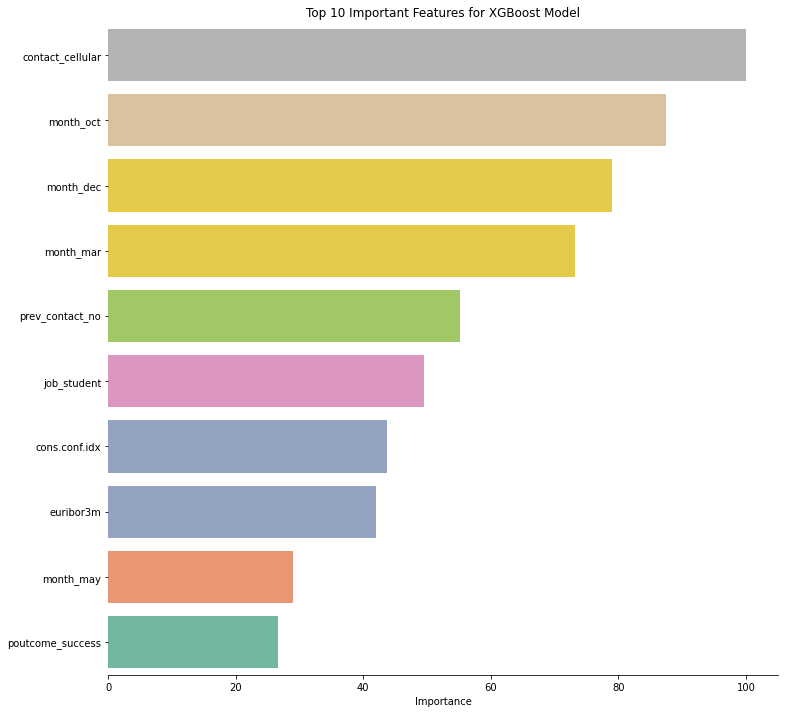

In [17]:
# create a feature importance dataframe
feat_importance = xgb_best.feature_importances_
feat_importance_df = pd.DataFrame(
    {'feature': bank_feats_train.columns, 'importance': feat_importance}
)
feat_importance_df.sort_values(
    'importance', ascending=False, inplace=True)
feat_importance_df.set_index('feature', inplace=True, drop=True)

# plot the top 10 importances
feat_importance = 100 * (feat_importance / feat_importance.max())
indices = np.argsort(feat_importance)[::-1][:10]
plt.figure(figsize=(12, 12))
sns.barplot(
    feat_importance[indices], bank_feats_train.columns[indices], orient='h', palette='Set2_r')
sns.despine(left=True)
plt.xlabel('Importance')
plt.title('Top 10 Important Features for XGBoost Model')
plt.savefig(join(visuals_dir, 'feat_importance.png'))
plt.show()